In [1]:
import skimage
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from skimage.draw import disk

In [2]:
np.random.seed(173)

In [3]:
def get_target_picture(name) :
    print("Target picture:")
    target_picture = io.imread(name)
    io.imshow(target_picture) 
    io.show()
    print("Shape: ", target_picture.shape)
    return target_picture

In [4]:
def put_image(board, image, position) :
    dx, dy = image.shape[0], image.shape[1]
    x, y = position[0], position[1]
    board[x:x + dx, y:y + dy, :] = image

In [5]:
def sim(img_a, img_b) :
    dif = img_a - img_b
    return np.sum(dif ** 2)

In [6]:
class tile() :
    
    color = (0, 0, 0)
    
    def init(self, col) :
        self.color = col
    
    def mutate_color(self, idx, shift) :
        self.color[idx] += np.random.randint(-shift, shift + 1)
        self.color = np.clip(self.color, 0, 255)
        
        

In [7]:
class individual() :
    
    N = 0
    size = 0
    tiles = []
    
    def init(self, _N, _size, tls) :
        self.N = _N
        self.size = _size
        self.tiles = tls
    
    def draw(self, tp) :
        X, Y = tp.shape[0], tp.shape[1]
        ret = np.zeros((X, Y, 3), dtype=int)
        pos_x = 0
        while(pos_x < X) :
            pos_y = 0
            while(pos_y < Y) :
                ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = copy.deepcopy(self.tiles[0].color)
                pos_y += self.size
            pos_x += self.size
        for i in range(1, self.N) :
            col = copy.deepcopy(self.tiles[i].color)
            pos_x = 0
            while(pos_x < X) :
                pos_y = 0
                while(pos_y < Y) :
                    prev_col = copy.deepcopy(ret[pos_x][pos_y])
                    prev_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = col
                    cur_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    if(cur_local_fitness > prev_local_fitness) :
                        ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = prev_col
                    pos_y += self.size
                pos_x += self.size
        return ret

In [8]:
def random_individual(N, tile_size) :
    tls = []
    for i in range(0, N) :
        cur_tile = tile()
        cur_tile.init(np.random.randint(0, 256, size = 3))
        tls.append(cur_tile)
    ret = individual()
    ret.init(N, tile_size, tls)
    return ret

In [9]:
def point_score(target_pic, ind) :
    return sim(ind.draw(target_pic), target_pic)

In [10]:
def run_ES(target_pic, save_pic = -1, save_path = "", number_of_tiles = 3, tile_size = 14, threshold1 = 5, threshold2 = 2, th1 = 2, th2 = 4, th3 = 10, rg1 = 50, rg2 = 20, rg3 = 10, init_population = 30, stay_alive = 15, steps = 300) :
    
    best = []
    best_fitness = int(1e18)
    population = []

    best_fitness_after_steps = np.zeros(steps + 1)
    best_pics = []
    
    for p in range(0, init_population) :
        ind = random_individual(number_of_tiles, tile_size)
        population.append(ind)

    population = np.array(population)
    
    for step in tqdm(range(0, steps + 1)) :
        
        children = copy.deepcopy(population)
        np.random.shuffle(children)
    
        L = len(population)
        for i in range(L) :
            ch = children[i]
            for ti in range(number_of_tiles) :
                if(np.random.randint(0, 2) == 0) :
                    ch.tiles[ti] = copy.deepcopy(population[i].tiles[ti])
                th = 0
                rg = 0
                if(step < steps / threshold1) :
                    th = th1
                    rg = rg1
                elif (step < steps / threshold2) :
                    th = th2
                    rg = rg2
                else :
                    th = th3
                    rg = rg3
                if(np.random.randint(0, th) == 0) :
                    ch.tiles[ti].mutate_color(np.random.randint(0, 3), rg)
    
        population = np.concatenate((population, children), axis=0)
        order = np.argsort([point_score(target_pic, x) for x in population], axis=0)
        population = population[order]
        population = population[0:stay_alive]
    
        if(point_score(target_pic, population[0]) < best_fitness) :
            best_fitness = point_score(target_pic, population[0])
            best = population[0]
        
        best_fitness_after_steps[step] = best_fitness
        
        if(save_pic != -1 and step % save_pic == 0) :
            print("Seps: ", step, "best_fitness: ", best_fitness)
            cur_path = save_path + str(step) + ".jpg"
            print("Saving to ", cur_path)
            pic = best.draw(target_pic)
            io.imsave(cur_path, pic) 
            
    return best_fitness_after_steps
    

In [11]:
def make_tests(tests, target, _number_of_tiles, _tile_size, _th1, _th2, _th3, _rg1, _rg2, _rg3, _steps = 300) :
    
    bfas = np.zeros(_steps + 1)
    
    for test in range(0, tests) :
        print("Test ", test + 1)
        results = run_ES(target_pic = target, number_of_tiles = _number_of_tiles, tile_size = _tile_size, th1 = _th1, th2 = _th2, th3 = _th3, rg1 = _rg1, rg2 = _rg2, rg3 = _rg3, steps = _steps)
        bfas += results
    
    bfas /= tests
    return bfas

In [12]:
TH3 = [0, 2, 4, 10]
RG3 = [0, 50, 20, 10]

TH8 = [0, 4, 8, 20]
RG8 = [0, 50, 20, 10]

TH15 = [0, 5, 10, 25]
RG15 = [0, 50, 20, 10]

Target picture:


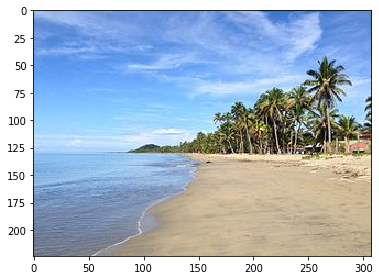

Shape:  (224, 308, 3)


  0%|                                                   | 0/301 [00:00<?, ?it/s]

Seps:  0 best_fitness:  249922438
Saving to  color-tiles/8col/plaza0.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza0.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [46, 245]. Convert image to uint8 prior to saving to suppress this warning.
  3%|█▍                                        | 10/301 [01:39<41:40,  8.59s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza10.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [33, 221]. Convert image to uint8 prior to saving to suppress this warning.
  4%|█▌                                        | 11/301 [01:46<39:47,  8.23s/it]

Seps:  10 best_fitness:  192662268
Saving to  color-tiles/8col/plaza10.jpg


  7%|██▊                                       | 20/301 [03:22<45:19,  9.68s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza20.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [44, 255]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██▉                                       | 21/301 [03:30<42:26,  9.10s/it]

Seps:  20 best_fitness:  151039476
Saving to  color-tiles/8col/plaza20.jpg


 10%|████▏                                     | 30/301 [04:36<32:41,  7.24s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza30.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [44, 252]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████▎                                     | 31/301 [04:46<35:34,  7.91s/it]

Seps:  30 best_fitness:  140648435
Saving to  color-tiles/8col/plaza30.jpg


 13%|█████▌                                    | 40/301 [06:08<33:53,  7.79s/it]

Seps:  40 best_fitness:  136701706
Saving to  color-tiles/8col/plaza40.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza40.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [45, 255]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████▉                                   | 50/301 [07:45<37:11,  8.89s/it]

Seps:  50 best_fitness:  135591293
Saving to  color-tiles/8col/plaza50.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza50.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [40, 252]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████▎                                 | 60/301 [09:06<29:53,  7.44s/it]

Seps:  60 best_fitness:  134738256
Saving to  color-tiles/8col/plaza60.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza60.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [60, 255]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████▊                                | 70/301 [10:25<29:25,  7.64s/it]

Seps:  70 best_fitness:  132877360
Saving to  color-tiles/8col/plaza70.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza70.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [54, 255]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████▏                              | 80/301 [11:51<37:16, 10.12s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza80.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 244]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████▎                              | 81/301 [12:03<38:44, 10.57s/it]

Seps:  80 best_fitness:  130021142
Saving to  color-tiles/8col/plaza80.jpg


 30%|████████████▌                             | 90/301 [13:51<41:06, 11.69s/it]

Seps:  90 best_fitness:  128897267
Saving to  color-tiles/8col/plaza90.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza90.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████▌                           | 100/301 [15:28<36:14, 10.82s/it]

Seps:  100 best_fitness:  126614225
Saving to  color-tiles/8col/plaza100.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza100.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [47, 255]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████▉                          | 110/301 [17:31<38:29, 12.09s/it]

Seps:  110 best_fitness:  126030245
Saving to  color-tiles/8col/plaza110.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza110.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 40%|████████████████▎                        | 120/301 [19:22<32:06, 10.64s/it]

Seps:  120 best_fitness:  125886532
Saving to  color-tiles/8col/plaza120.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza120.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 43%|█████████████████▋                       | 130/301 [21:12<33:53, 11.89s/it]

Seps:  130 best_fitness:  125507582
Saving to  color-tiles/8col/plaza130.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza130.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████                      | 140/301 [22:42<21:38,  8.06s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza140.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████▏                     | 141/301 [22:50<21:20,  8.01s/it]

Seps:  140 best_fitness:  124987289
Saving to  color-tiles/8col/plaza140.jpg


 50%|████████████████████▍                    | 150/301 [24:01<20:27,  8.13s/it]

Seps:  150 best_fitness:  124722817
Saving to  color-tiles/8col/plaza150.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza150.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 53%|█████████████████████▊                   | 160/301 [25:27<22:17,  9.48s/it]

Seps:  160 best_fitness:  124536900
Saving to  color-tiles/8col/plaza160.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza160.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 255]. Convert image to uint8 prior to saving to suppress this warning.
 56%|███████████████████████▏                 | 170/301 [27:05<17:05,  7.83s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza170.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 248]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████▎                 | 171/301 [27:12<16:20,  7.54s/it]

Seps:  170 best_fitness:  124328963
Saving to  color-tiles/8col/plaza170.jpg


 60%|████████████████████████▌                | 180/301 [28:39<21:22, 10.60s/it]

Seps:  180 best_fitness:  124141241
Saving to  color-tiles/8col/plaza180.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza180.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 250]. Convert image to uint8 prior to saving to suppress this warning.
 63%|█████████████████████████▉               | 190/301 [30:15<14:11,  7.67s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza190.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 250]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████               | 191/301 [30:22<13:42,  7.48s/it]

Seps:  190 best_fitness:  123960551
Saving to  color-tiles/8col/plaza190.jpg


 66%|███████████████████████████▏             | 200/301 [31:35<15:58,  9.49s/it]

Seps:  200 best_fitness:  123825197
Saving to  color-tiles/8col/plaza200.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza200.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [57, 250]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████▌            | 210/301 [33:21<15:53, 10.48s/it]

Seps:  210 best_fitness:  123718870
Saving to  color-tiles/8col/plaza210.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza210.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 73%|█████████████████████████████▉           | 220/301 [34:59<13:12,  9.79s/it]

Seps:  220 best_fitness:  123625218
Saving to  color-tiles/8col/plaza220.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza220.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 76%|███████████████████████████████▎         | 230/301 [36:51<11:40,  9.87s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza230.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████▍         | 231/301 [36:58<10:31,  9.02s/it]

Seps:  230 best_fitness:  123623946
Saving to  color-tiles/8col/plaza230.jpg


 80%|████████████████████████████████▋        | 240/301 [38:30<11:24, 11.22s/it]

Seps:  240 best_fitness:  123567298
Saving to  color-tiles/8col/plaza240.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza240.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████       | 250/301 [39:47<06:18,  7.41s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza250.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████▏      | 251/301 [39:55<06:25,  7.71s/it]

Seps:  250 best_fitness:  123563070
Saving to  color-tiles/8col/plaza250.jpg


 86%|███████████████████████████████████▍     | 260/301 [41:12<06:50, 10.01s/it]

Seps:  260 best_fitness:  123543119
Saving to  color-tiles/8col/plaza260.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza260.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████▊    | 270/301 [42:55<04:14,  8.22s/it]/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza270.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████▉    | 271/301 [43:02<03:55,  7.84s/it]

Seps:  270 best_fitness:  123531010
Saving to  color-tiles/8col/plaza270.jpg


 93%|██████████████████████████████████████▏  | 280/301 [44:21<02:59,  8.53s/it]

Seps:  280 best_fitness:  123513673
Saving to  color-tiles/8col/plaza280.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza280.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
 96%|███████████████████████████████████████▌ | 290/301 [45:56<01:33,  8.49s/it]

Seps:  290 best_fitness:  123451970
Saving to  color-tiles/8col/plaza290.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza290.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
100%|████████████████████████████████████████▊| 300/301 [47:50<00:11, 11.89s/it]

Seps:  300 best_fitness:  123416867
Saving to  color-tiles/8col/plaza300.jpg


/tmp/ipykernel_1897337/3482741245.py:57: UserWarning: color-tiles/8col/plaza300.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [59, 250]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████| 301/301 [48:02<00:00,  9.57s/it]


array([2.49922438e+08, 2.49922438e+08, 2.38449394e+08, 2.35540568e+08,
       2.25069781e+08, 2.15681440e+08, 2.15681440e+08, 2.09710625e+08,
       2.08267868e+08, 1.98189571e+08, 1.92662268e+08, 1.90847297e+08,
       1.75435952e+08, 1.75435952e+08, 1.71818825e+08, 1.66813174e+08,
       1.56705553e+08, 1.51039476e+08, 1.51039476e+08, 1.51039476e+08,
       1.51039476e+08, 1.51039476e+08, 1.51039476e+08, 1.51039476e+08,
       1.50516988e+08, 1.49325799e+08, 1.48319686e+08, 1.43775325e+08,
       1.43775325e+08, 1.40648435e+08, 1.40648435e+08, 1.40648435e+08,
       1.40648435e+08, 1.40033361e+08, 1.39672483e+08, 1.38437038e+08,
       1.38437038e+08, 1.38268037e+08, 1.36701706e+08, 1.36701706e+08,
       1.36701706e+08, 1.36701706e+08, 1.36701706e+08, 1.36625026e+08,
       1.36625026e+08, 1.36488660e+08, 1.35749446e+08, 1.35749446e+08,
       1.35749446e+08, 1.35749446e+08, 1.35591293e+08, 1.35591293e+08,
       1.35531065e+08, 1.35531065e+08, 1.35531065e+08, 1.34924124e+08,
      

In [13]:
cur_target = get_target_picture('plaza_ok.jpg')
run_ES(target_pic = cur_target, save_pic = 10, save_path = 'color-tiles/8col/plaza', number_of_tiles = 8, tile_size = 7, th1 = TH8[1], th2 = TH8[2], th3 = TH8[3], rg1 = RG8[1], rg2 = RG8[2], rg3 = RG8[3])

In [14]:
data = make_tests(tests = 5, target = cur_target, _number_of_tiles = 8, _tile_size = 7, _th1 = TH8[1], _th2 = TH8[2], _th3 = TH8[3], _rg1 = RG8[1], _rg2 = RG8[2], _rg3 = RG8[3])

Test  1


100%|█████████████████████████████████████████| 301/301 [41:34<00:00,  8.29s/it]


Test  2


100%|█████████████████████████████████████████| 301/301 [42:18<00:00,  8.43s/it]


Test  3


100%|█████████████████████████████████████████| 301/301 [51:12<00:00, 10.21s/it]


Test  4


100%|█████████████████████████████████████████| 301/301 [44:43<00:00,  8.92s/it]


Test  5


100%|█████████████████████████████████████████| 301/301 [42:57<00:00,  8.56s/it]


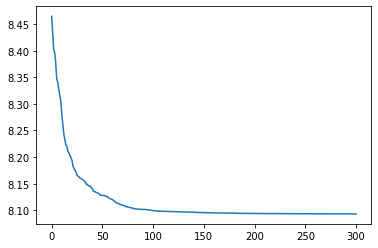

In [15]:
plt.figure()
plt.plot(np.log10(data))
plt.show()

In [16]:
file_to_save = open("color-tiles/8col/col8plaza.txt", "w")
np.savetxt(file_to_save, data)
file_to_save.close()